In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch
import tensorboardX

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [5]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def create_all_codones(df):
    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        seq = row
        for i in range(3):
            yield make_codones(seq[i:])    

In [7]:
all_codones_f = lambda: create_all_codones(seq_df)

iter = all_codones_f()
print([next(iter) for i in range(10)])

[['MAF', 'SAE', 'DVL', 'KEY', 'DRR', 'RRM', 'EAL', 'LLS', 'LYY', 'PND', 'RKL', 'LDY', 'KEW', 'SPP', 'RVQ', 'VEC', 'PKA', 'PVE', 'WNN', 'PPS', 'EKG', 'LIV', 'GHF', 'SGI', 'KYK', 'GEK', 'AQA', 'SEV', 'DVN', 'KMC', 'CWV', 'SKF', 'KDA', 'MRR', 'YQG', 'IQT', 'CKI', 'PGK', 'VLS', 'DLD', 'AKI', 'KAY', 'NLT', 'VEG', 'VEG', 'FVR', 'YSR', 'VTK', 'QHV', 'AAF', 'LKE', 'LRH', 'SKQ', 'YEN', 'VNL', 'IHY', 'ILT', 'DKR', 'VDI', 'QHL', 'EKD', 'LVK', 'DFK', 'ALV', 'ESA', 'HRM', 'RQG', 'HMI', 'NVK', 'YIL', 'YQL', 'LKK', 'HGH', 'GPD', 'GPD', 'ILT', 'VKT', 'GSK', 'GVL', 'YDD', 'SFR', 'KIY', 'TDL', 'GWK', 'FTP'], ['AFS', 'AED', 'VLK', 'EYD', 'RRR', 'RME', 'ALL', 'LSL', 'YYP', 'NDR', 'KLL', 'DYK', 'EWS', 'PPR', 'VQV', 'ECP', 'KAP', 'VEW', 'NNP', 'PSE', 'KGL', 'IVG', 'HFS', 'GIK', 'YKG', 'EKA', 'QAS', 'EVD', 'VNK', 'MCC', 'WVS', 'KFK', 'DAM', 'RRY', 'QGI', 'QTC', 'KIP', 'GKV', 'LSD', 'LDA', 'KIK', 'AYN', 'LTV', 'EGV', 'EGF', 'VRY', 'SRV', 'TKQ', 'HVA', 'AFL', 'KEL', 'RHS', 'KQY', 'ENV', 'NLI', 'HYI', 'LTD', 'K

In [8]:
######################

In [9]:
def generate_sample(index_words_list_f, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list_f():
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    for i, sublist in enumerate(x):
        if ((i & (i - 1)) == 0):
            print("flatter iter {}".format(i))
        for item in sublist:
            yield item

def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones_f, dictionary, batch_size, skip_window):
    cod_dicts_f = lambda: (cod_to_dict(cod, dictionary) for cod in all_codones_f())
    single_gen = generate_sample(cod_dicts_f, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [49]:
class WordSampler:
    def __init__(self, word_count, samples):
        word_count_smooth = word_count ** 0.75
        self.distr = word_count_smooth / word_count_smooth.sum() 
        self.samples = samples
        
    def sample(self, batch_size):
        return torch.LongTensor(np.random.choice(len(self.distr), size=(batch_size, self.samples), p=self.distr))

In [12]:
dictionary = make_dictionary(all_codones_f())

flatter iter 0
flatter iter 1
flatter iter 2
flatter iter 4
flatter iter 8
flatter iter 16
flatter iter 32
flatter iter 64
flatter iter 128
flatter iter 256


flatter iter 512


flatter iter 1024


flatter iter 2048


flatter iter 4096


flatter iter 8192


flatter iter 16384


flatter iter 32768


flatter iter 65536


flatter iter 131072


flatter iter 262144


flatter iter 524288


In [13]:
word_count = np.zeros(len(dictionary))
for word in flatten(all_codones_f()):
    word_count[dictionary[word]] += 1

flatter iter 0
flatter iter 1
flatter iter 2
flatter iter 4
flatter iter 8
flatter iter 16
flatter iter 32
flatter iter 64
flatter iter 128
flatter iter 256


flatter iter 512


flatter iter 1024


flatter iter 2048


flatter iter 4096


flatter iter 8192


flatter iter 16384


flatter iter 32768


flatter iter 65536


flatter iter 131072


flatter iter 262144


flatter iter 524288


[1.61152335e-04 5.85412899e-05 3.47811842e-05 ... 5.49525240e-05
 1.40122021e-04 1.35353985e-04]


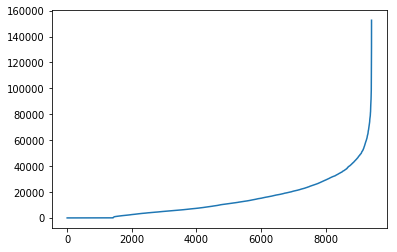

In [20]:

print(word_count / word_count.sum())
plt.plot([i for i in range(len(word_count))], sorted(word_count))

In [20]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones_f, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [20]:
######################

In [132]:
class SkipGramModel(nn.Module):
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.v_embeddings = nn.Embedding(vocab_size, embed_size)
        self.u_embeddings = nn.Embedding(vocab_size, embed_size).cuda()
        init_range = 0.5 / (embed_size ** 0.5)
        self.v_embeddings.weight.data.uniform_(-init_range, init_range)
        self.u_embeddings.weight.data.uniform_(-0, 0)
        
        self.v_embeddings = self.v_embeddings.cuda()
        self.u_embeddings = self.u_embeddings.cuda()
        
    def forward(self, center, positive, negative, device):
        self.v_embeddings = self.v_embeddings.to(device)
        self.u_embeddings = self.u_embeddings.to(device)
        v_center = self.v_embeddings(center)
        u_pos = self.u_embeddings(positive)
        u_neg = self.u_embeddings(negative)
        
        pos_loss = F.logsigmoid(
            torch.mul(u_pos, v_center).sum(dim=1)
        ).mean()
        
        neg_loss = F.logsigmoid(
            -1 * torch.bmm(u_neg, v_center.unsqueeze(2)).squeeze().sum(dim=1)
        ).mean()
        return -(pos_loss + neg_loss)
    
    def get_embeddings(self):
        return self.v_embeddings.weight.clone().detach().numpy()

In [123]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .1
NUM_TRAIN_STEPS = 200000
SKIP_STEP = 2000

print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


In [124]:
######################

In [125]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [ ]:
def train_model(device, model, batch_gen, num_train_steps, optimizer, skip_step, neg_sampler):
    make_dir('checkpoints')
    total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
    for index in range(1, 1 + num_train_steps):
        center, target = next(batch_gen)
        center, target = torch.LongTensor(center), torch.LongTensor(target)
        batch_size = len(center)
        neg_samples = neg_sampler.sample(batch_size)
        
        optimizer.zero_grad()
        center, target, neg_samples = center.to(device), target.to(device), neg_samples.to(device)
            
        loss = model.forward(center, target, neg_samples, device)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        if (index + 1) % skip_step == 0:
            print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
            total_loss = 0.0
    return model.get_embeddings()

In [133]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
neg_sampler = WordSampler(word_count, NUM_SAMPLED)
embed_matrix = train_model(device, model, batch_gen, NUM_TRAIN_STEPS, optimizer, SKIP_STEP, neg_sampler)

TypeError: forward() missing 1 required positional argument: 'device'

In [ ]:
######################

In [60]:
tsne = TSNE(n_components=2, random_state=42)
print(embed_matrix)
XX = tsne.fit_transform(embed_matrix)

[[ 3.2058628e-03  1.1486793e-03 -3.5310863e-03 ... -3.5342225e-03
  -5.8866758e-03  3.8717510e-03]
 [-1.3512598e-03  3.7529354e-03  7.1582349e-04 ...  3.3480625e-03
  -4.0094238e-03 -3.0620466e-03]
 [-2.7426931e-03  6.4686661e-05 -4.6371710e-03 ... -4.4668121e-03
  -3.2565244e-03 -3.2932400e-03]
 ...
 [ 6.6581229e-04  3.4823408e-03  3.1733587e-03 ... -4.9532359e-03
  -2.0899044e-03  3.8738754e-03]
 [ 1.3714917e-04 -2.1885903e-04 -1.2398855e-03 ... -1.0201150e-03
  -1.6103809e-03  2.6451638e-03]
 [ 4.4993004e-03 -9.7811967e-04 -4.7459113e-03 ... -1.5621203e-03
  -2.7271446e-03 -3.8354408e-03]]


In [ ]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-24.663631,-2.361643,DIL
1,39.391209,-26.825081,FSW
2,-1.295716,-9.931656,QLS
3,2.340122,28.970411,FHE
4,-51.491653,-4.323871,EKQ


In [ ]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

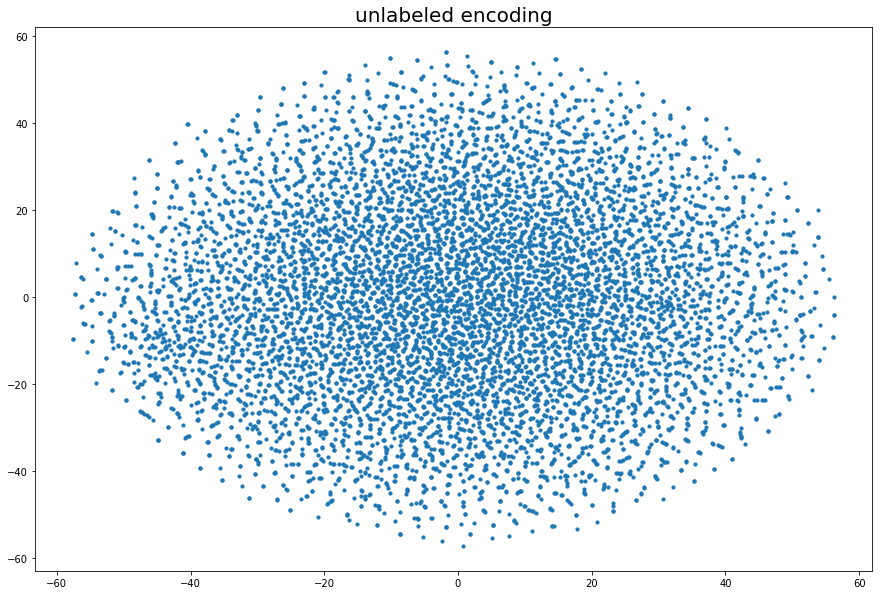

In [ ]:
plot_tsne_df(tsne_df)

In [ ]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [65]:
######################

In [66]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [67]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [68]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,TQA,-0.800000,100.103667,16.666667,116.166667
1,RCI,0.833333,124.162067,20.666667,149.533333
2,GKT,-1.666667,95.442500,17.000000,114.933333
3,MXL,2.850000,122.176850,21.000000,164.800000
4,WHE,-2.533333,150.821067,22.000000,173.133333


In [69]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,TQA,-0.800000,100.103667,16.666667,116.166667,-22.615622,0.750837
1,RCI,0.833333,124.162067,20.666667,149.533333,3.657538,6.619569
2,GKT,-1.666667,95.442500,17.000000,114.933333,-45.648277,-11.401894
3,MXL,2.850000,122.176850,21.000000,164.800000,-4.590923,14.216729
4,WHE,-2.533333,150.821067,22.000000,173.133333,1.545542,-32.418137


In [70]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

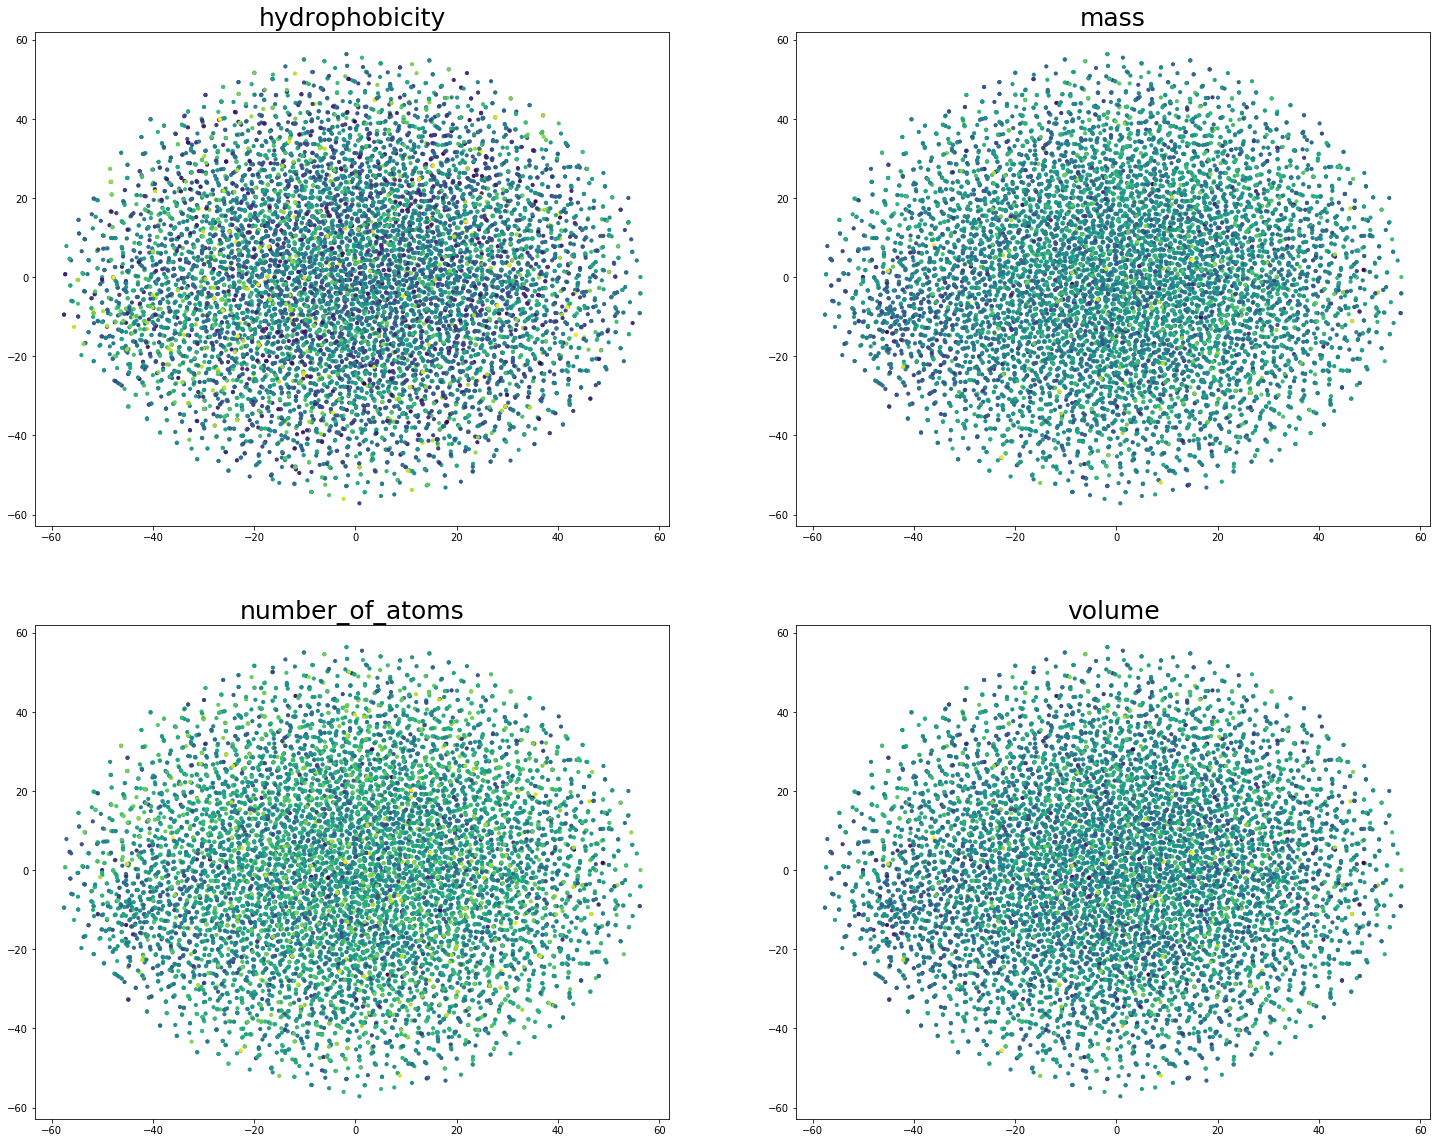

In [71]:
plot_embedding_properties(final_df)

In [72]:
summaryWriter = tensorboardX.SummaryWriter()
summaryWriter.add_embedding(embed_matrix)
summaryWriter.close()

In [ ]:
######################

In [21]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

In [22]:
plot_tsne_df(gensim_tsne_df)

NameError: name 'plot_tsne_df' is not defined

In [23]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

NameError: name 'all_acid_df' is not defined

In [24]:
plot_embedding_properties(final_df_nice)

NameError: name 'plot_embedding_properties' is not defined

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [25]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59

SyntaxError: invalid syntax (<ipython-input-25-fdda3a90776c>, line 1)